In [58]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
# load names data set into a list of words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [60]:
# assign each unique character in the data set a unique number mapping 
# remove duplicate letters
c_set = set(''.join(words))
chars = sorted(list(c_set))

# create a dictionary that assigns each letter in the chars list an integer
# stoi is shifted one, a = 1, so that '.' = 0
stoi = {s:i+1 for i, s in enumerate(chars)} # char to int dict
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # int to char dict
vocab_size = len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [61]:
# build data set
block_size = 3 # context length

def build_dataset(words):
    X, Y = [], []

    for w in words:

        # context is a rolling window over the word of size 3, always behind the current char in loop below
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '----->', itos[ix])
            
            # shift context window
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_tr, Y_tr = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_te, Y_te = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [82]:
# MLP from makemore_v2 a little modified
n_embd = 10 # the dim of the character emedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

gain = 5/3

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden), generator=g) * (gain/(block_size * n_embd))
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0.0

bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))
bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bn_gain, bn_bias]
print(sum(p.nelement() for p in parameters)) # number of parameters in the network
for p in parameters:
    p.requires_grad = True

12097


In [83]:
# same optimization as v2 ( with additions )
# training loop
epochs = 200000
batch_size = 32
lossi = []

for i in range(epochs):

    # minibatch construction
    ix = torch.randint(0, X_tr.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_tr[ix], Y_tr[ix] # bach X, Y
    
    # forward pass and the loss expressing the accuracy with the loss
    emb = C[Xb] 
    embcat = emb.view(emb.shape[0], -1)
    h_pre = embcat @ W1 # + b1
    
    bn_meani = h_pre.mean(0, keepdim=True)
    bn_stdi = h_pre.std(0, keepdim=True)
    
    # batch normalization ( with batch gain and bias)
    h_pre = bn_gain * (h_pre - bn_meani)/  bn_stdi + bn_bias 

    # update running statistics
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_meani
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_stdi
        
    h = torch.tanh(h_pre)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update parameters and learning rate
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0708
  20000/ 200000: 2.5805
  30000/ 200000: 1.9092
  40000/ 200000: 2.2693
  50000/ 200000: 1.8409
  60000/ 200000: 2.0878
  70000/ 200000: 2.5052
  80000/ 200000: 2.3542
  90000/ 200000: 2.0701
 100000/ 200000: 2.2845
 110000/ 200000: 2.3070
 120000/ 200000: 1.6271
 130000/ 200000: 1.8989
 140000/ 200000: 2.1822
 150000/ 200000: 1.9763
 160000/ 200000: 2.0145
 170000/ 200000: 2.4254
 180000/ 200000: 2.1256
 190000/ 200000: 2.0937


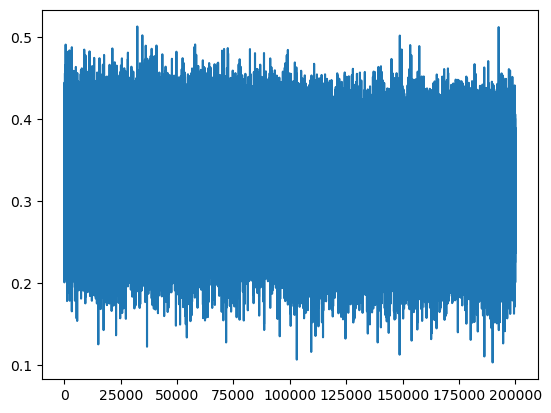

In [76]:
plt.close('all')
plt.plot(lossi)
plt.show()

In [77]:
# calibrate the batch norm at the end of training
# getting the stats from all the training set to use during infrence

with torch.no_grad():
    # pass the training set through
    emb = C[X_tr]
    embcat = emb.view(emb.shape[0], -1)
    h_pre = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bn_mean = h_pre.mean(0, keepdim=True)
    bn_std = h_pre.std(0, keepdim=True)

In [78]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train' : (X_tr, Y_tr),
        'val' : (X_dev, Y_dev),
        'test' : (X_te, Y_te),
    }[split]
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    h_pre = embcat @ W1 + b1
    h_pre = bn_gain * (h_pre - bn_mean_running)/ bn_std_running + bn_bias 
    h = torch.tanh(h_pre)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) # loss function
    print(split, loss.item())

split_loss('train')
split_loss('val')
    

train 2.2339649200439453
val 2.2339649200439453
